In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import glob
import pickle
from collections import defaultdict, Counter
import warnings
import Bio.PDB
import gctree

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_51559/1507017736.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
out_dir = "output/mutations"

## DMS single AA mutant effects on affinity

In [4]:
# dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/improved-Kd-fitting/tite-seq-modeling/output/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,19.0,2.0,6.78608,-0.07452,17.0,2.0,8.743409,0.118716,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,20.0,2.0,7.44234,0.58174,17.0,2.0,8.608721,-0.015972,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,16.0,2.0,6.95940,0.09880,13.0,2.0,8.636242,0.011550,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,21170.0,2.0,6.86060,0.00000,18910.0,2.0,NaN,NaN,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,24.0,2.0,6.91372,0.05313,21.0,2.0,8.758316,0.133624,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,39.0,2.0,6.93925,0.07866,33.0,2.0,8.634747,0.010054,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,36.0,2.0,6.88956,0.02896,34.0,2.0,8.644639,0.019946,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,27.0,2.0,6.78160,-0.07899,24.0,2.0,8.589500,-0.035193,False,L-128


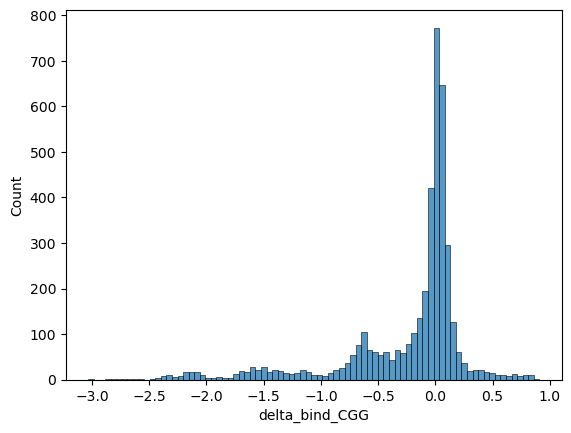

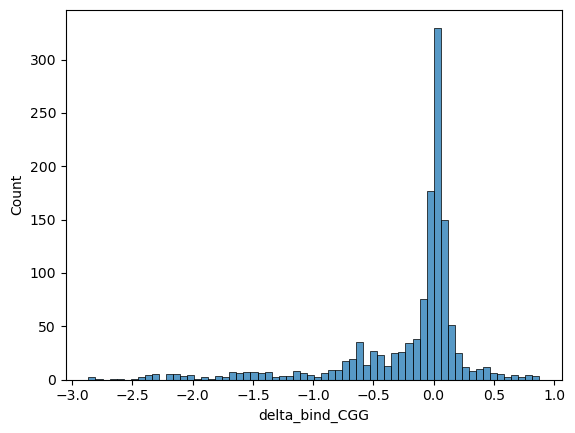

In [5]:
sns.histplot(data=dms_df, x="delta_bind_CGG")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG")
plt.show()

In [6]:
dms_df.loc[dms_df.single_nt].delta_bind_CGG.describe()

count    1283.000000
mean       -0.203425
std         0.544056
min        -2.864795
25%        -0.265182
50%        -0.004111
75%         0.054141
max         0.877291
Name: delta_bind_CGG, dtype: float64

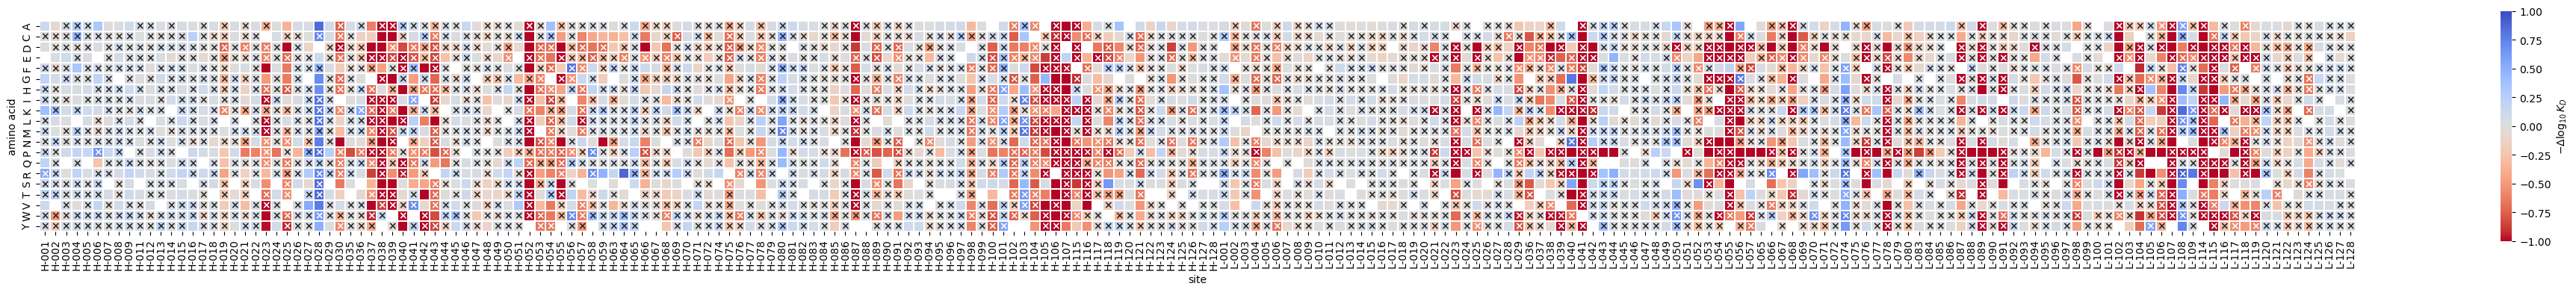

In [7]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind_CGG")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = 1
vmin = -1

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df,
            center=0, vmin=vmin, vmax=vmax,
            annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.bind.pdf")
plt.show()

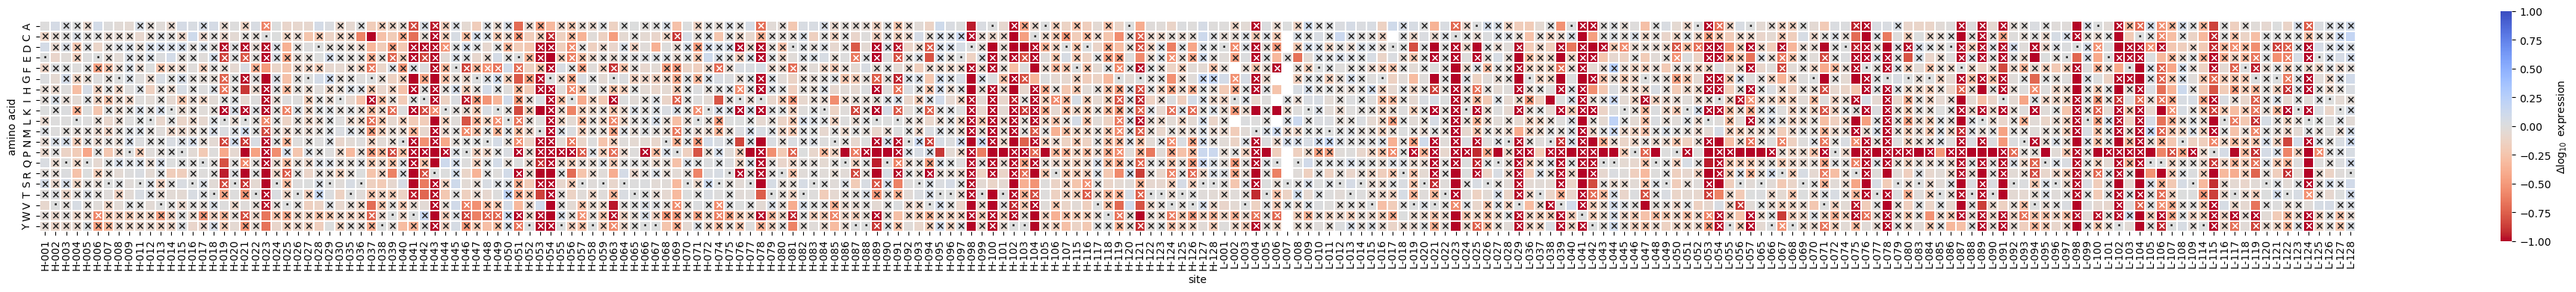

In [8]:
expr_df = dms_df.pivot(index="mutant", columns="site", values="delta_expr")

plt.figure(figsize=(50, 4))
sns.heatmap(expr_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10}$ expression"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.expr.pdf")
plt.show()

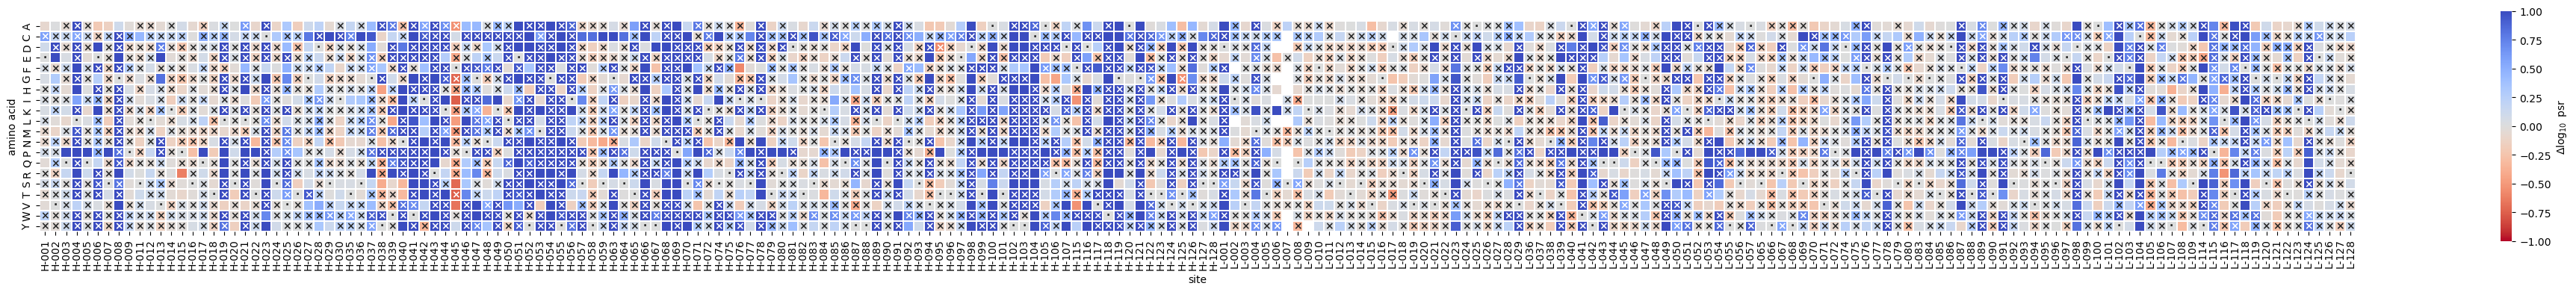

In [9]:
psr_df = dms_df.pivot(index="mutant", columns="site", values="delta_psr")

plt.figure(figsize=(50, 4))
sns.heatmap(psr_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10}$ psr"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.psr.pdf")
plt.show()

## Mutations in GC trees

In [10]:
results = "../nextflow/results"

In [11]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[0].split(".")[0][2:]), int(PR_str[1]), PR_str[3]

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("PR", "mouse", "GC"), gc_key(file)))
    print(key)
    # if key.startswith("mouse7") or key.startswith("mouse8"):
    #     print(f"skipping 10-week {key}")
    #     continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

PR1_mouse1_GC1
PR1_mouse1_GC11
PR1_mouse1_GC12
PR1_mouse1_GC13
PR1_mouse1_GC14
PR1_mouse1_GC15
PR1_mouse1_GC16
PR1_mouse1_GC17
PR1_mouse1_GC18
PR1_mouse1_GC19
PR1_mouse1_GC2
PR1_mouse1_GC20
PR1_mouse1_GC3
PR1_mouse1_GC4
PR1_mouse1_GC5
PR1_mouse1_GC6
PR1_mouse1_GC7
PR1_mouse2_GC21
PR1_mouse2_GC22
PR1_mouse2_GC23
PR1_mouse2_GC24
PR1_mouse2_GC25
PR1_mouse2_GC26
PR1_mouse2_GC28
PR1_mouse2_GC29
PR1_mouse2_GC30
PR1_mouse2_GC31
PR1_mouse2_GC32
PR1_mouse2_GC34
PR1_mouse2_GC38
PR1_mouse2_GC39
PR1_mouse2_GC40
PR1_mouse3_GC41
PR1_mouse3_GC42
PR1_mouse3_GC43
PR1_mouse3_GC44
PR1_mouse3_GC45
PR1_mouse3_GC46
PR1_mouse3_GC55
PR1_mouse3_GC56
PR1_mouse3_GC57
PR1_mouse3_GC58
PR1_mouse3_GC59
PR1_mouse3_GC64
PR1_mouse3_GC65
PR1_mouse3_GC66
PR1_mouse3_GC72
PR1_mouse4_GC47
PR1_mouse4_GC48
PR1_mouse4_GC50
PR1_mouse4_GC63
PR1_mouse4_GC67
PR1_mouse4_GC68
PR1_mouse4_GC69
PR1_mouse4_GC70
PR1_mouse4_GC71
PR1_mouse4_GC73
PR1_mouse5_GC78
PR1_mouse5_GC79
PR1_mouse5_GC80
PR1_mouse5_GC81
PR1_mouse5_GC82
PR1_mouse5_GC83

GC metadata

In [12]:
metadata_PR1 = pd.read_csv("../metadata.PR1.csv")[["imm_duration", "strain", "mouse", "gc", "node", "cell_type"]]
metadata_PR1["pr"] = "1"
metadata_PR1["gc"] = metadata_PR1["gc"].astype(str)
metadata_PR1.rename({"imm_duration": "time"}, axis=1, inplace=True)
metadata_PR2 = pd.read_csv("../metadata.PR2.csv")[["mouse", "gc", "node", "cell_type"]]
metadata_PR2["pr"] = "2"
metadata_PR2["time"] = "d15"
metadata_PR2["strain"] = "wt"

metadata = pd.concat([metadata_PR1, metadata_PR2], ignore_index=True)
metadata.index = "PR" + metadata["pr"] + "_mouse" + metadata["mouse"].astype(str) + "_GC" + metadata["gc"]
metadata

,time,strain,mouse,gc,node,cell_type,pr
PR1_mouse1_GC1,d20,wt,1,1,RP,GC,1
PR1_mouse1_GC2,d20,wt,1,2,RP,GC,1
PR1_mouse1_GC3,d20,wt,1,3,RP,GC,1
PR1_mouse1_GC4,d20,wt,1,4,LP,GC,1
PR1_mouse1_GC5,d20,wt,1,5,LP,GC,1
...,...,...,...,...,...,...,...
PR2_mouse12_GC12B,d15,wt,12,12B,LP,GC,2
PR2_mouse12_GC12D,d15,wt,12,12D,LI,GC,2
PR2_mouse12_GC12C,d15,wt,12,12C,RI,GC,2
PR2_mouse10_GC10A,d15,wt,10,10A,RP,GC,2


In [13]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [14]:
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,19.0,2.0,6.78608,-0.07452,17.0,2.0,8.743409,0.118716,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,20.0,2.0,7.44234,0.58174,17.0,2.0,8.608721,-0.015972,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,16.0,2.0,6.95940,0.09880,13.0,2.0,8.636242,0.011550,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,21170.0,2.0,6.86060,0.00000,18910.0,2.0,NaN,NaN,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,24.0,2.0,6.91372,0.05313,21.0,2.0,8.758316,0.133624,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,39.0,2.0,6.93925,0.07866,33.0,2.0,8.634747,0.010054,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,36.0,2.0,6.88956,0.02896,34.0,2.0,8.644639,0.019946,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,27.0,2.0,6.78160,-0.07899,24.0,2.0,8.589500,-0.035193,False,L-128


In [15]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Mutation events

In [18]:
metadata.query("pr == '1'").gc

PR1_mouse1_GC1         1
PR1_mouse1_GC2         2
PR1_mouse1_GC3         3
PR1_mouse1_GC4         4
PR1_mouse1_GC5         5
                    ... 
PR1_mouse12_GC126    126
PR1_mouse12_GC127    127
PR1_mouse12_GC128    128
PR1_mouse12_GC129    129
PR1_mouse12_GC130    130
Name: gc, Length: 97, dtype: object

In [23]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

dms_df["mutation events (15-day)"] = 0
dms_df["mutation events (20-day)"] = 0
dms_df["mutation events (10-week)"] = 0
dms_df["mutation events (LMP2A)"] = 0

for gc, tree in trees.items():
    if gc not in metadata.index:
        raise ValueError(f"GC {gc} not found in metadata!")
    if (metadata.strain[gc] == "wt") and (metadata.time[gc] == "d15"):
        suffix = "15-day"
    elif (metadata.strain[gc] == "wt") and (metadata.time[gc] == "d20"):
        suffix = "20-day"
    elif (metadata.strain[gc] == "wt") and (metadata.time[gc] == "w10"):
        suffix = "10-week"
    elif (metadata.strain[gc] == "LMP2A"):
        suffix = "LMP2A"
    else:
        raise ValueError(f"unknown gc {gc}")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        for mutation in set(node.mutations) - set(node.up.mutations):
            mutant = mutation[-1]
            if mutant != "*":
                site = dms_df.site[mutation]
                hits_df.loc[mutant, site] += 1
                dms_df.loc[mutation, f"mutation events ({suffix})"] += 1

# NOTE: "total" mutation events means day 15 and day 20
dms_df["mutation events"] = dms_df["mutation events (15-day)"] + dms_df["mutation events (20-day)"]

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128
mutant,,,,,,,,,,,,,,,,,,,,,
A,4.0,4.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,...,8.0,9.0,0.0,3.0,1.0,1.0,7.0,2.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,16.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,36.0,0.0,0.0,0.0
E,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,8.0,0.0,41.0,0.0,0.0,0.0,37.0,0.0
F,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
G,9.0,2.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,13.0,...,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
H,0.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,6.0,1.0,2.0,0.0,0.0,17.0,0.0
K,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.0,21.0,0.0,0.0


In [24]:
dms_df.loc["A105(H)G"]

target                       CGG_naive
wildtype                             A
position                            96
position_IMGT                      105
chain                                H
annotation                       CDRH3
mutant                               G
codon                              GCA
single_nt                         True
bind_CGG_old                  10.78819
n_bc_bind_CGG                     15.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.25772
delta_bind_TuGG               -0.08157
n_bc_bind_TuGG                    17.0
n_libs_bind_TuGG                   2.0
expr                          10.44506
delta_expr                    -0.00561
n_bc_expr                         18.0
n_libs_expr                        2.0
psr                            6.58706
delta_psr                     -0.27353
n_bc_psr                          15.0
n_libs_psr                         2.0
bind_CGG                      9.070766
delta_bind_CGG           

In [25]:
hits_df.max().max()

411.0

## Comparing mutation incidence across mouse types

accessible mutations observed in 20-day mice: 894
accessible mutations not observed in 20-day mice: 611
inaccessible mutations observed in 20-day mice: 135
inaccessible mutations not observed in 20-day mice: 2760
accessible mutations observed in 10-week mice: 487
accessible mutations not observed in 10-week mice: 1018
inaccessible mutations observed in 10-week mice: 70
inaccessible mutations not observed in 10-week mice: 2825


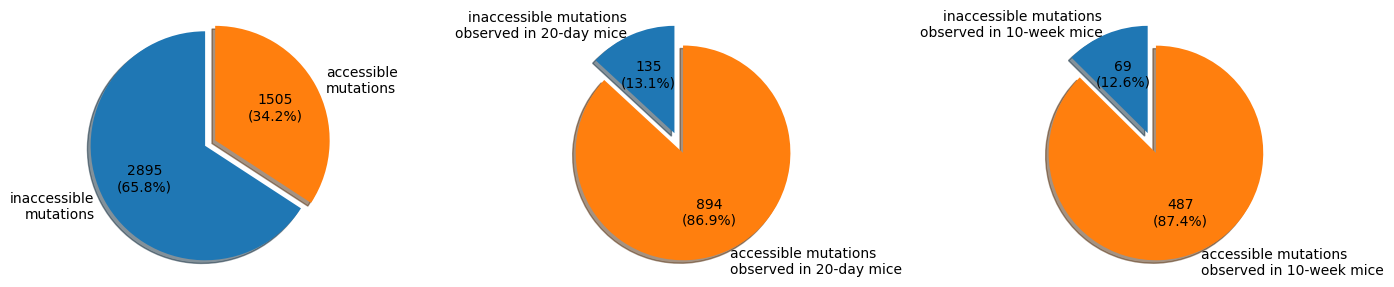

In [27]:
print(f"accessible mutations observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"accessible mutations not observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")
print(f"inaccessible mutations observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"inaccessible mutations not observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")

print(f"accessible mutations observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"accessible mutations not observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")
print(f"inaccessible mutations observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"inaccessible mutations not observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")

def func(pct, data):
    absolute = int(pct / 100 * np.sum(data))
    return f"{absolute:d}\n({pct:.1f}%)"

plt.figure(figsize=(14, 3))

plt.subplot(131)
data = [len(dms_df) - sum(dms_df.single_nt), sum(dms_df.single_nt)]
plt.pie(data,
        labels=("inaccessible\nmutations", "accessible\nmutations"),
        explode=(0, 0.1), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(132)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 20-day mice", "accessible mutations\nobserved in 20-day mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(133)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 10-week mice", "accessible mutations\nobserved in 10-week mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.tight_layout()
plt.savefig(f"{out_dir}/piechart.pdf")
plt.show()

# sns.boxplot(data=dms_df, x="single_nt", y="mutation events (20-day)")
# plt.show()

# sns.stripplot(data=dms_df, x="single_nt", y="mutation events (10-week)")
# plt.show()

In [28]:
dms_df[["single_nt", "mutation events (20-day)"]]

,single_nt,mutation events (20-day)
mutation,,
E1(H)A,True,4
E1(H)C,False,0
E1(H)D,True,7
E1(H)E,True,0
E1(H)F,False,0
...,...,...
R128(L)S,True,0
R128(L)T,False,0
R128(L)V,False,0


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

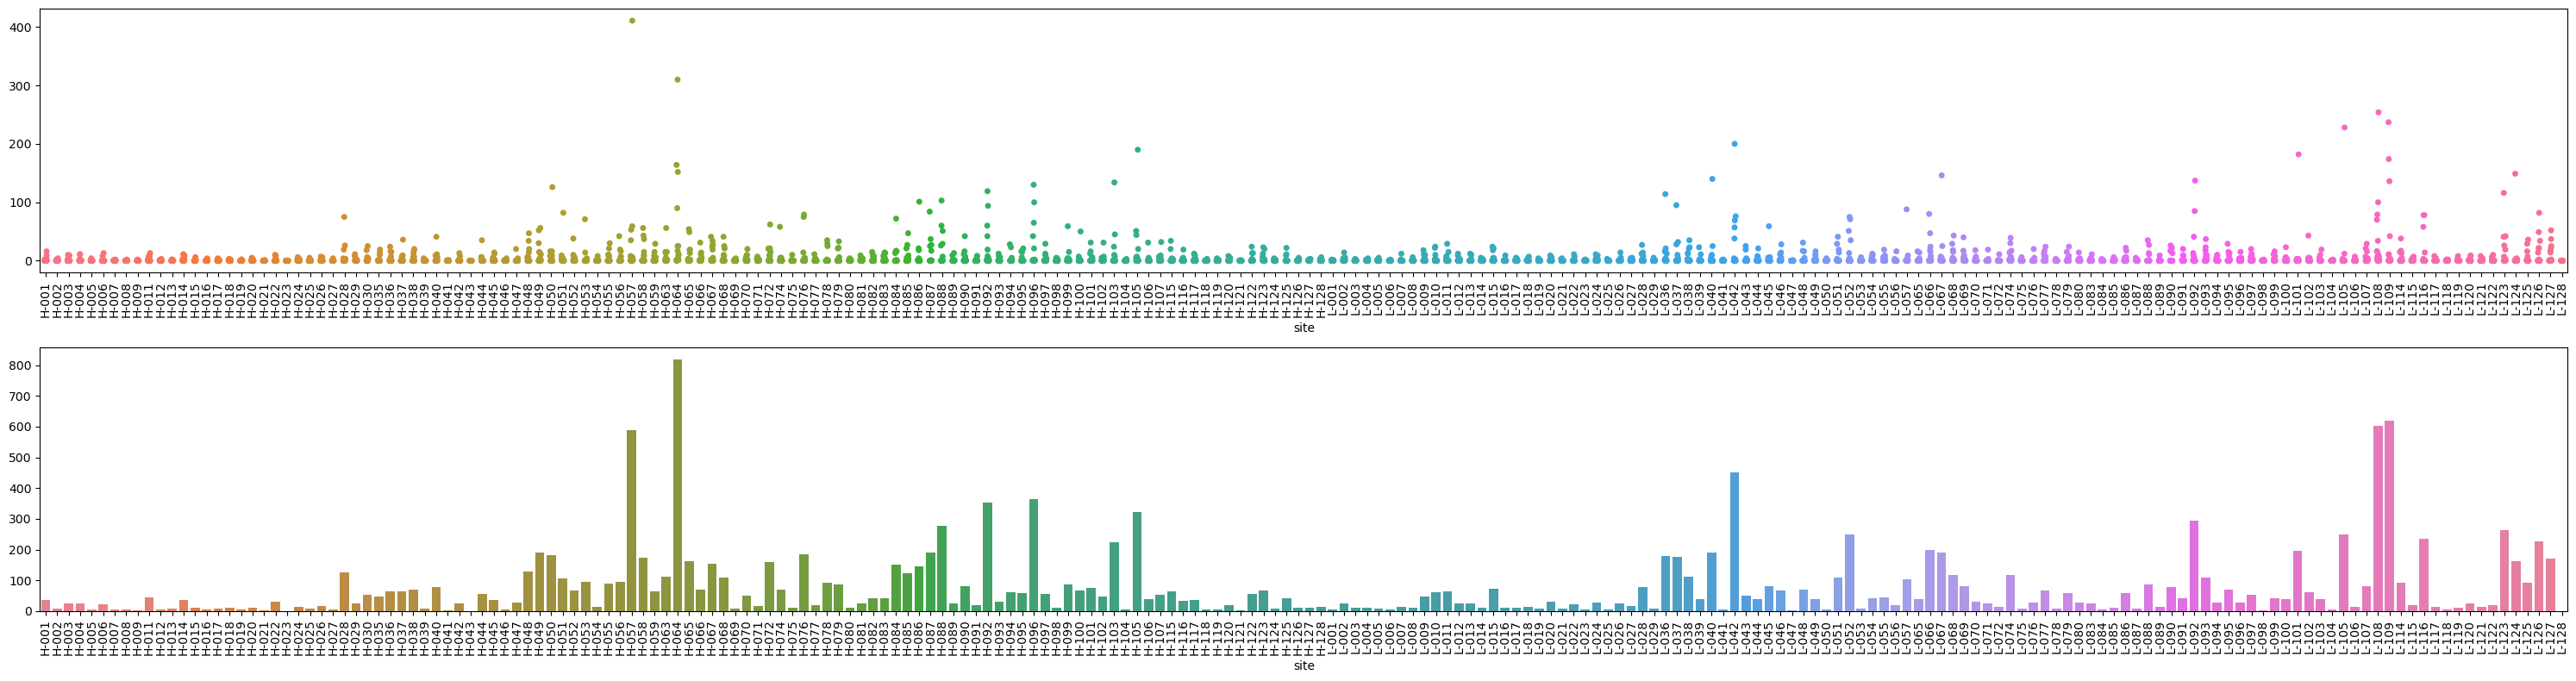

In [29]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, errorbar=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

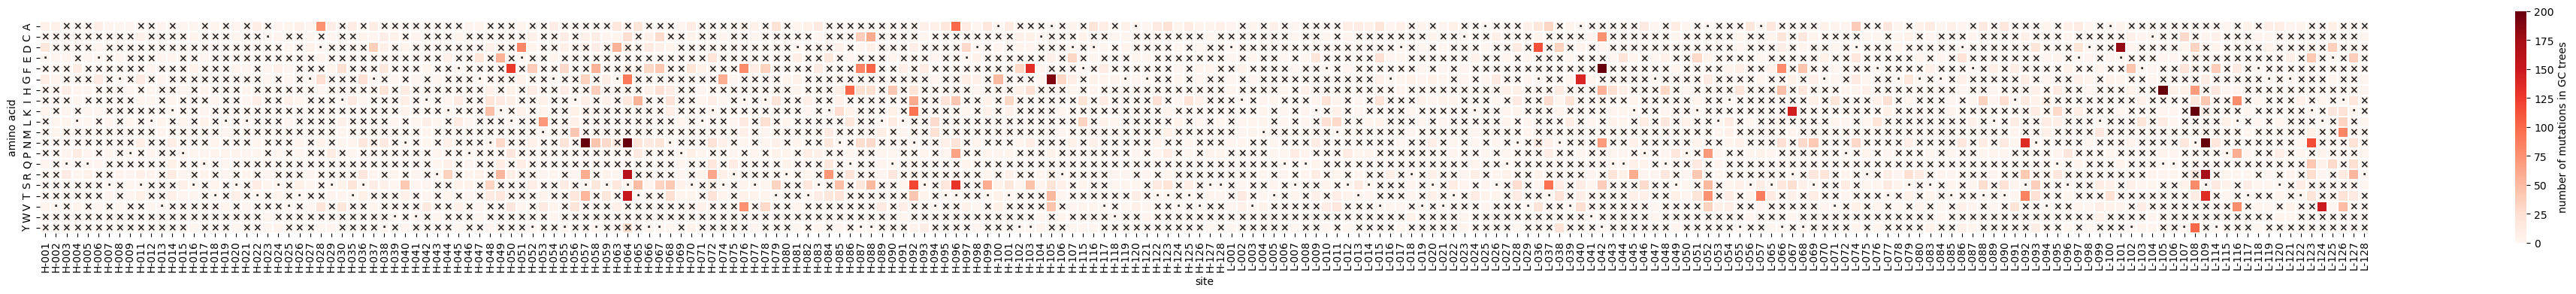

In [30]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="Reds",
#             vmin=100,
            vmax=200,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

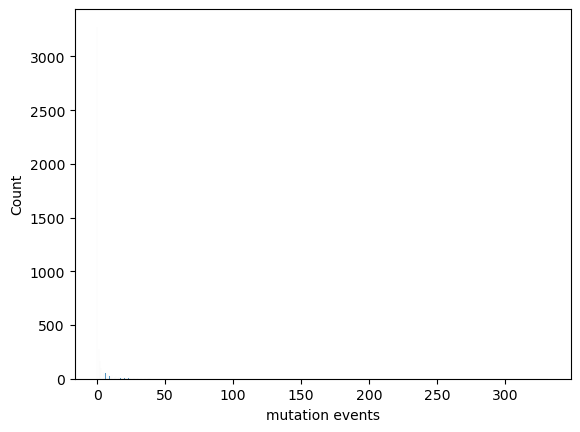

mutation
S57(H)N     332
S64(H)N     242
N108(L)K    202
S109(L)N    179
Q105(L)H    175
E101(L)D    148
A105(H)G    148
S109(L)R    142
Y42(L)F     142
S64(H)R     124
L124(L)V    120
R67(L)K     117
S64(H)T     117
A40(L)G     112
T96(H)S     108
S92(L)N     102
S109(L)T    101
Y103(H)F     98
G36(L)D      97
L50(H)F      95
Name: mutation events, dtype: int64

In [31]:
sns.histplot(data=dms_df, x="mutation events")
plt.show()

dms_df["mutation events"].sort_values(ascending=False)[:20]

## Add mutability to `dms_df`

In [156]:
assert (~dms_df.single_nt & (dms_df["mutation rate"] > 0)).sum() == 0

In [32]:
from Bio.codonalign.codonseq import CodonSeq


chigy_hc_passenger = pd.read_csv("../passenger/output/chigy_hc_mutation_rates_nt.csv", index_col=0)
chigy_lc_passenger = pd.read_csv("../passenger/output/chigy_lc_mutation_rates_nt.csv", index_col=0)

pd.concat([chigy_hc_passenger.tail(1), chigy_lc_passenger.head(1)])
mutation_rates_nt_passenger = pd.concat([chigy_hc_passenger.head(-1), chigy_lc_passenger.head(-1)])
# Assert that we've glued things together covering all sites
assert (mutation_rates_nt_passenger.index == np.arange(len(mutation_rates_nt_passenger))).all()

mutation_rates_nt = mutation_rates_nt_passenger


# mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
# substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igk_idx = 336

# padded_igh = "NN" + naive[:igk_idx] + "NN"
# padded_igk = "NN" + naive[igk_idx:] + "NN"
# # mutabilities of each nucleotide
# contexts = [padded_igh[(i - 2) : (i + 3)]
#                 for i in range(2, len(padded_igh) - 2)
#                ] + [padded_igk[(i - 2) : (i + 3)]
#                     for i in range(2, len(padded_igk) - 2)
#                    ]

# # mutation rates at each site in naive
# mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level

codons = CodonSeq(naive)

# assert len(contexts) == len(naive) == len(codons)

dms_df["mutation rate"] = 0

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_51559/3237652243.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001516694586849' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]


,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,bind_CGG,delta_bind_CGG,WT,site,mutation events (15-day),mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,8.743409,0.118716,False,H-001,0,4,0,0,4,0.000409
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,8.608721,-0.015972,False,H-001,0,0,0,0,0,0.000000
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,8.636242,0.011550,False,H-001,2,7,5,2,9,0.000803
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,NaN,NaN,True,H-001,0,0,0,0,0,0.000000
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,8.758316,0.133624,False,H-001,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,8.634747,0.010054,False,L-128,0,0,0,0,0,0.000000
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,8.644639,0.019946,False,L-128,0,0,0,0,0,0.000000
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,8.589500,-0.035193,False,L-128,0,0,0,0,0,0.000000


<Axes: xlabel='delta_bind_CGG', ylabel='Density'>

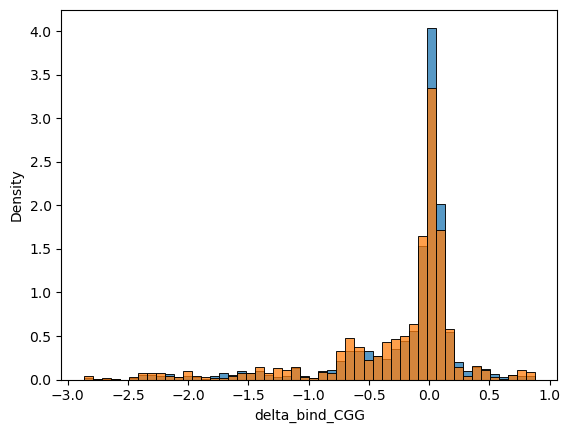

In [120]:
sns.histplot(data=dms_df.query("single_nt"), x="delta_bind_CGG", bins=50, stat="density")
sns.histplot(data=dms_df.query("single_nt"), x="delta_bind_CGG", weights="mutation rate", bins=50, stat="density")

In [33]:
dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate"]]

,delta_bind_CGG,wildtype,mutant,mutation events,mutation rate
mutation,,,,,
S109(L)T,0.016776,S,T,101,0.007625
S92(L)N,0.035227,S,N,102,0.006260
T96(H)S,0.042786,T,S,108,0.007994
A40(L)G,0.803875,A,G,112,0.000693
R67(L)K,0.154094,R,K,117,0.002907
S64(H)T,-0.028470,S,T,117,0.008689
L124(L)V,0.081313,L,V,120,0.010117
S64(H)R,0.877291,S,R,124,0.004439
Y42(L)F,-0.040251,Y,F,142,0.007751


In [34]:
dms_df.loc["N108(L)E"]

target                       CGG_naive
wildtype                             N
position                           219
position_IMGT                      108
chain                                L
annotation                       CDRL3
mutant                               E
codon                              AAC
single_nt                        False
bind_CGG_old                   9.54056
n_bc_bind_CGG                     37.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.11732
delta_bind_TuGG               -0.22197
n_bc_bind_TuGG                    40.0
n_libs_bind_TuGG                   2.0
expr                          10.36579
delta_expr                    -0.08488
n_bc_expr                         41.0
n_libs_expr                        2.0
psr                            6.60032
delta_psr                     -0.26028
n_bc_psr                          40.0
n_libs_psr                         2.0
bind_CGG                      7.902278
delta_bind_CGG           

In [35]:
pos_df.loc[90:100]

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
90,T,H,99,ACA,FWRH3
91,A,H,100,GCC,FWRH3
92,T,H,101,ACA,FWRH3
93,Y,H,102,TAT,FWRH3
94,Y,H,103,TAC,FWRH3
95,C,H,104,TGT,FWRH3
96,A,H,105,GCA,CDRH3
97,R,H,106,AGG,CDRH3
98,D,H,107,GAC,CDRH3


In [36]:
# most_mutated_df = dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate", "mutation rate RS5NF"]]

In [37]:
# plt.figure(figsize=(10, 8))  # Set the size of the plot

# # Create scatter plot
# plt.scatter(most_mutated_df['mutation rate'], most_mutated_df['mutation rate RS5NF'], alpha=0.6)

# # Label each point
# for i in range(len(most_mutated_df)):
#     plt.text(most_mutated_df['mutation rate'][i], most_mutated_df['mutation rate RS5NF'][i], most_mutated_df.index[i], fontsize=8)

# # Set labels and title
# plt.xlabel('Mutation Rate')
# plt.ylabel('Mutation Rate RS5NF')
# plt.title('Mutation Rate vs Mutation Rate RS5NF')

# plt.show()

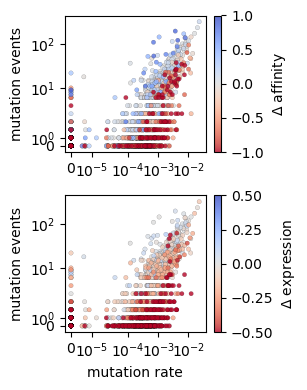

In [123]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
plt.scatter(data=dms_df.sort_values(by="delta_bind_CGG", key=lambda val: np.abs(val)), x="mutation rate", y="mutation events", c="delta_bind_CGG", s=10, alpha=0.8,
            cmap="coolwarm_r", vmin=-1, vmax=1,
            clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 3 * dms_df.loc[dms_df["mutation rate"] > 0, "mutation rate"].min()
linthresh_y = 6
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ affinity")

plt.subplot(212, sharex=ax)
plt.scatter(data=dms_df.sort_values(by="delta_expr", key=lambda val: np.abs(val)), x="mutation rate", y="mutation events", c="delta_expr", s=10, alpha=0.8,
            cmap="coolwarm_r", vmin=-0.5, vmax=0.5,
            clip_on=False, edgecolors="k", linewidths=0.1)
plt.xlabel("mutation rate")
plt.ylabel("mutation events")
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ expression")

plt.tight_layout()
plt.savefig(f"{out_dir}/eventsVsrate.pdf")
plt.show()

Event / rate Vs affinity (getting at selection sensitivity)

In [124]:
gain_thresh = 0.3
loss_thresh = -1
dms_df.loc[~dms_df.delta_bind_CGG.isna(), "affinity change stratum"] = "affinity neutral"
dms_df.loc[dms_df.delta_bind_CGG > gain_thresh, "affinity change stratum"] = "affinity gain"
dms_df.loc[dms_df.delta_bind_CGG < loss_thresh, "affinity change stratum"] = "affinity loss"

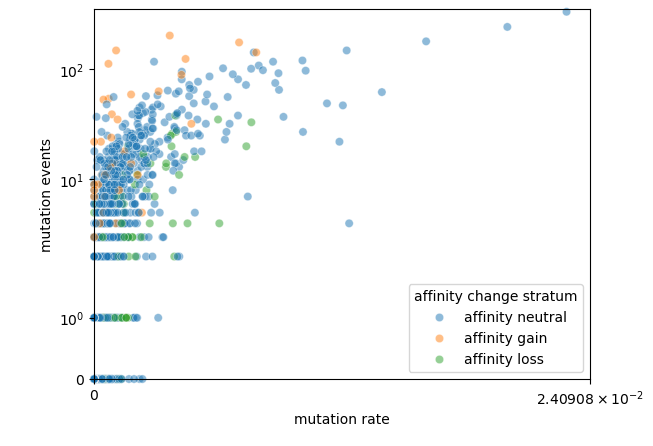

In [125]:
sns.scatterplot(data=dms_df, hue="affinity change stratum", y="mutation events", x="mutation rate", alpha=0.5, clip_on=False)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

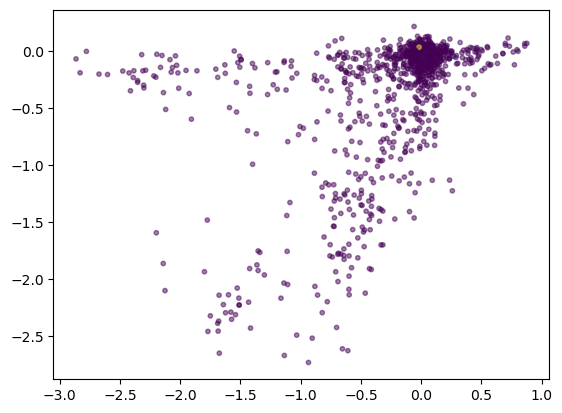

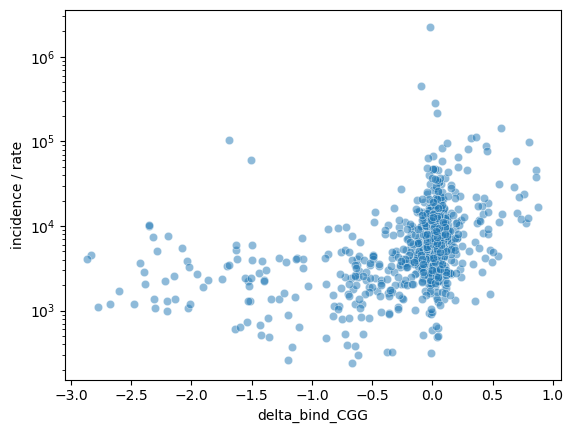

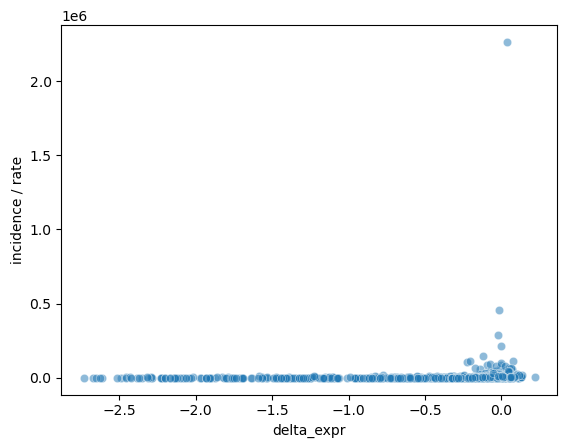

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


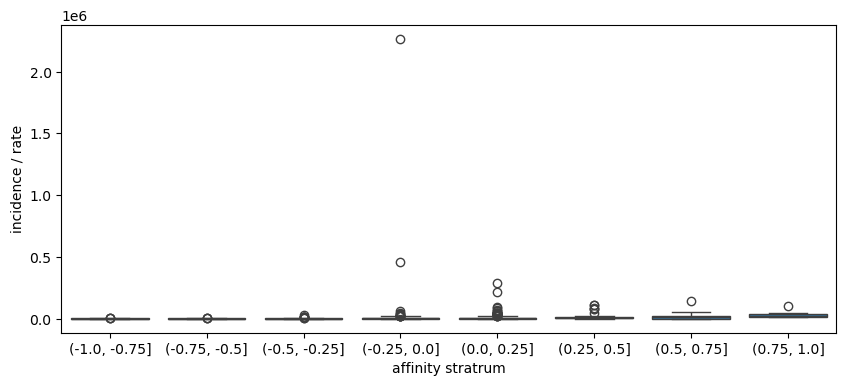

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


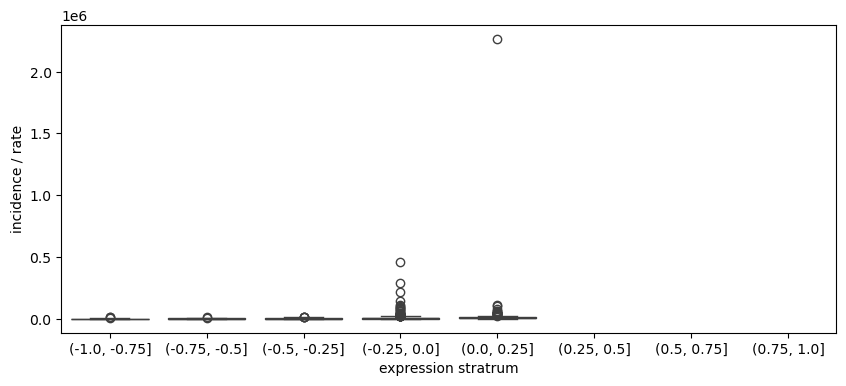

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


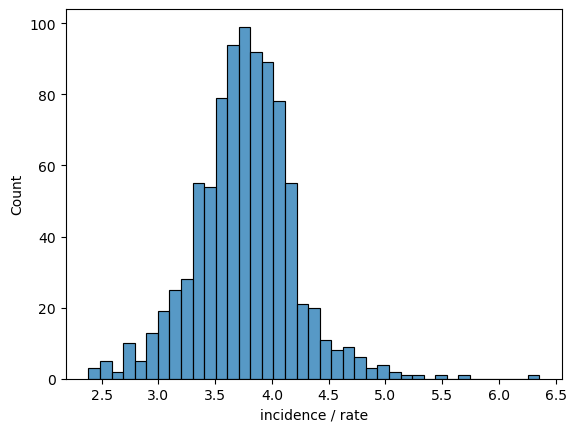

In [126]:
affinity_incidence_rate_df = dms_df[["delta_bind_CGG", "delta_expr", "mutation events (20-day)", "mutation rate"]].copy()
affinity_incidence_rate_df["incidence / rate"] = affinity_incidence_rate_df["mutation events (20-day)"] / affinity_incidence_rate_df["mutation rate"]

bins = np.linspace(-1, 1, 9)
affinity_incidence_rate_df["affinity stratrum"] = pd.cut(affinity_incidence_rate_df["delta_bind_CGG"], bins=bins)
affinity_incidence_rate_df["expression stratrum"] = pd.cut(affinity_incidence_rate_df["delta_expr"], bins=bins)

plt.scatter(affinity_incidence_rate_df.delta_bind_CGG, affinity_incidence_rate_df.delta_expr, c=affinity_incidence_rate_df["incidence / rate"], alpha=0.5, s=10)
plt.show()

sns.scatterplot(data=affinity_incidence_rate_df, x="delta_bind_CGG", y="incidence / rate", alpha=0.5)
plt.yscale("log")
plt.show()
sns.scatterplot(data=affinity_incidence_rate_df, x="delta_expr", y="incidence / rate", alpha=0.5)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="affinity stratrum", y="incidence / rate")
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

sns.histplot(x=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()

In [127]:
affinity_incidence_rate_df

,delta_bind_CGG,delta_expr,mutation events (20-day),mutation rate,incidence / rate,affinity stratrum,expression stratrum
mutation,,,,,,,
E1(H)A,0.118716,-0.00453,4,0.000409,9779.227998,"(0.0, 0.25]","(-0.25, 0.0]"
E1(H)C,-0.015972,-0.12703,0,0.000000,NaN,"(-0.25, 0.0]","(-0.25, 0.0]"
E1(H)D,0.011550,0.06551,7,0.000803,8713.689851,"(0.0, 0.25]","(0.0, 0.25]"
E1(H)E,NaN,0.00000,0,0.000000,NaN,NaN,"(-0.25, 0.0]"
E1(H)F,0.133624,-0.11904,0,0.000000,NaN,"(0.0, 0.25]","(-0.25, 0.0]"
...,...,...,...,...,...,...,...
R128(L)S,0.010054,0.09246,0,0.000000,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)T,0.019946,0.08793,0,0.000000,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)V,-0.035193,0.03640,0,0.000000,NaN,"(-0.25, 0.0]","(0.0, 0.25]"


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


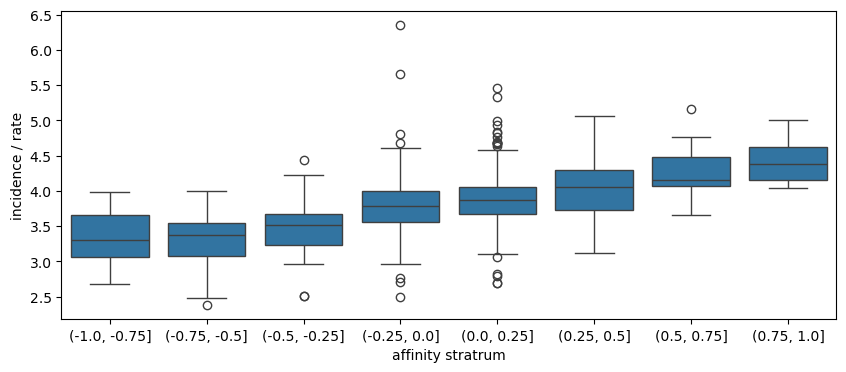

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


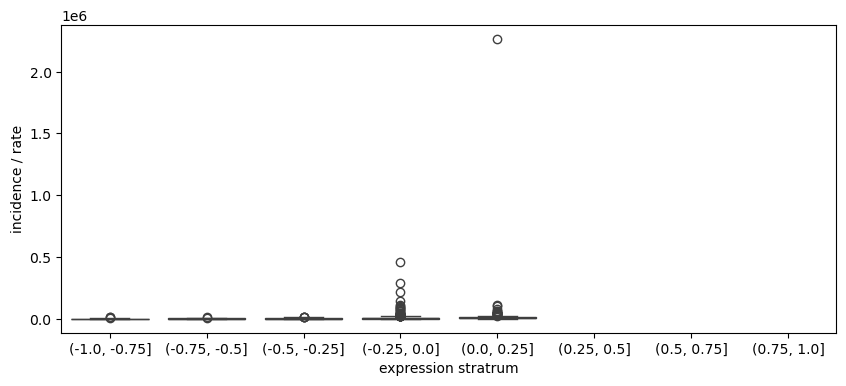

In [128]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=affinity_incidence_rate_df["affinity stratrum"], y=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

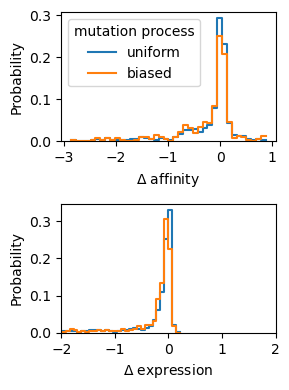

In [44]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
# plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ affinity")
# plt.yscale("log")
plt.legend(title="mutation process", fontsize=10)

plt.subplot(212)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ expression")
# plt.yscale("log")


# sns.jointplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", y="delta_expr")


plt.tight_layout()
plt.savefig(f"{out_dir}/mutation-bias.pdf")
plt.show()

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

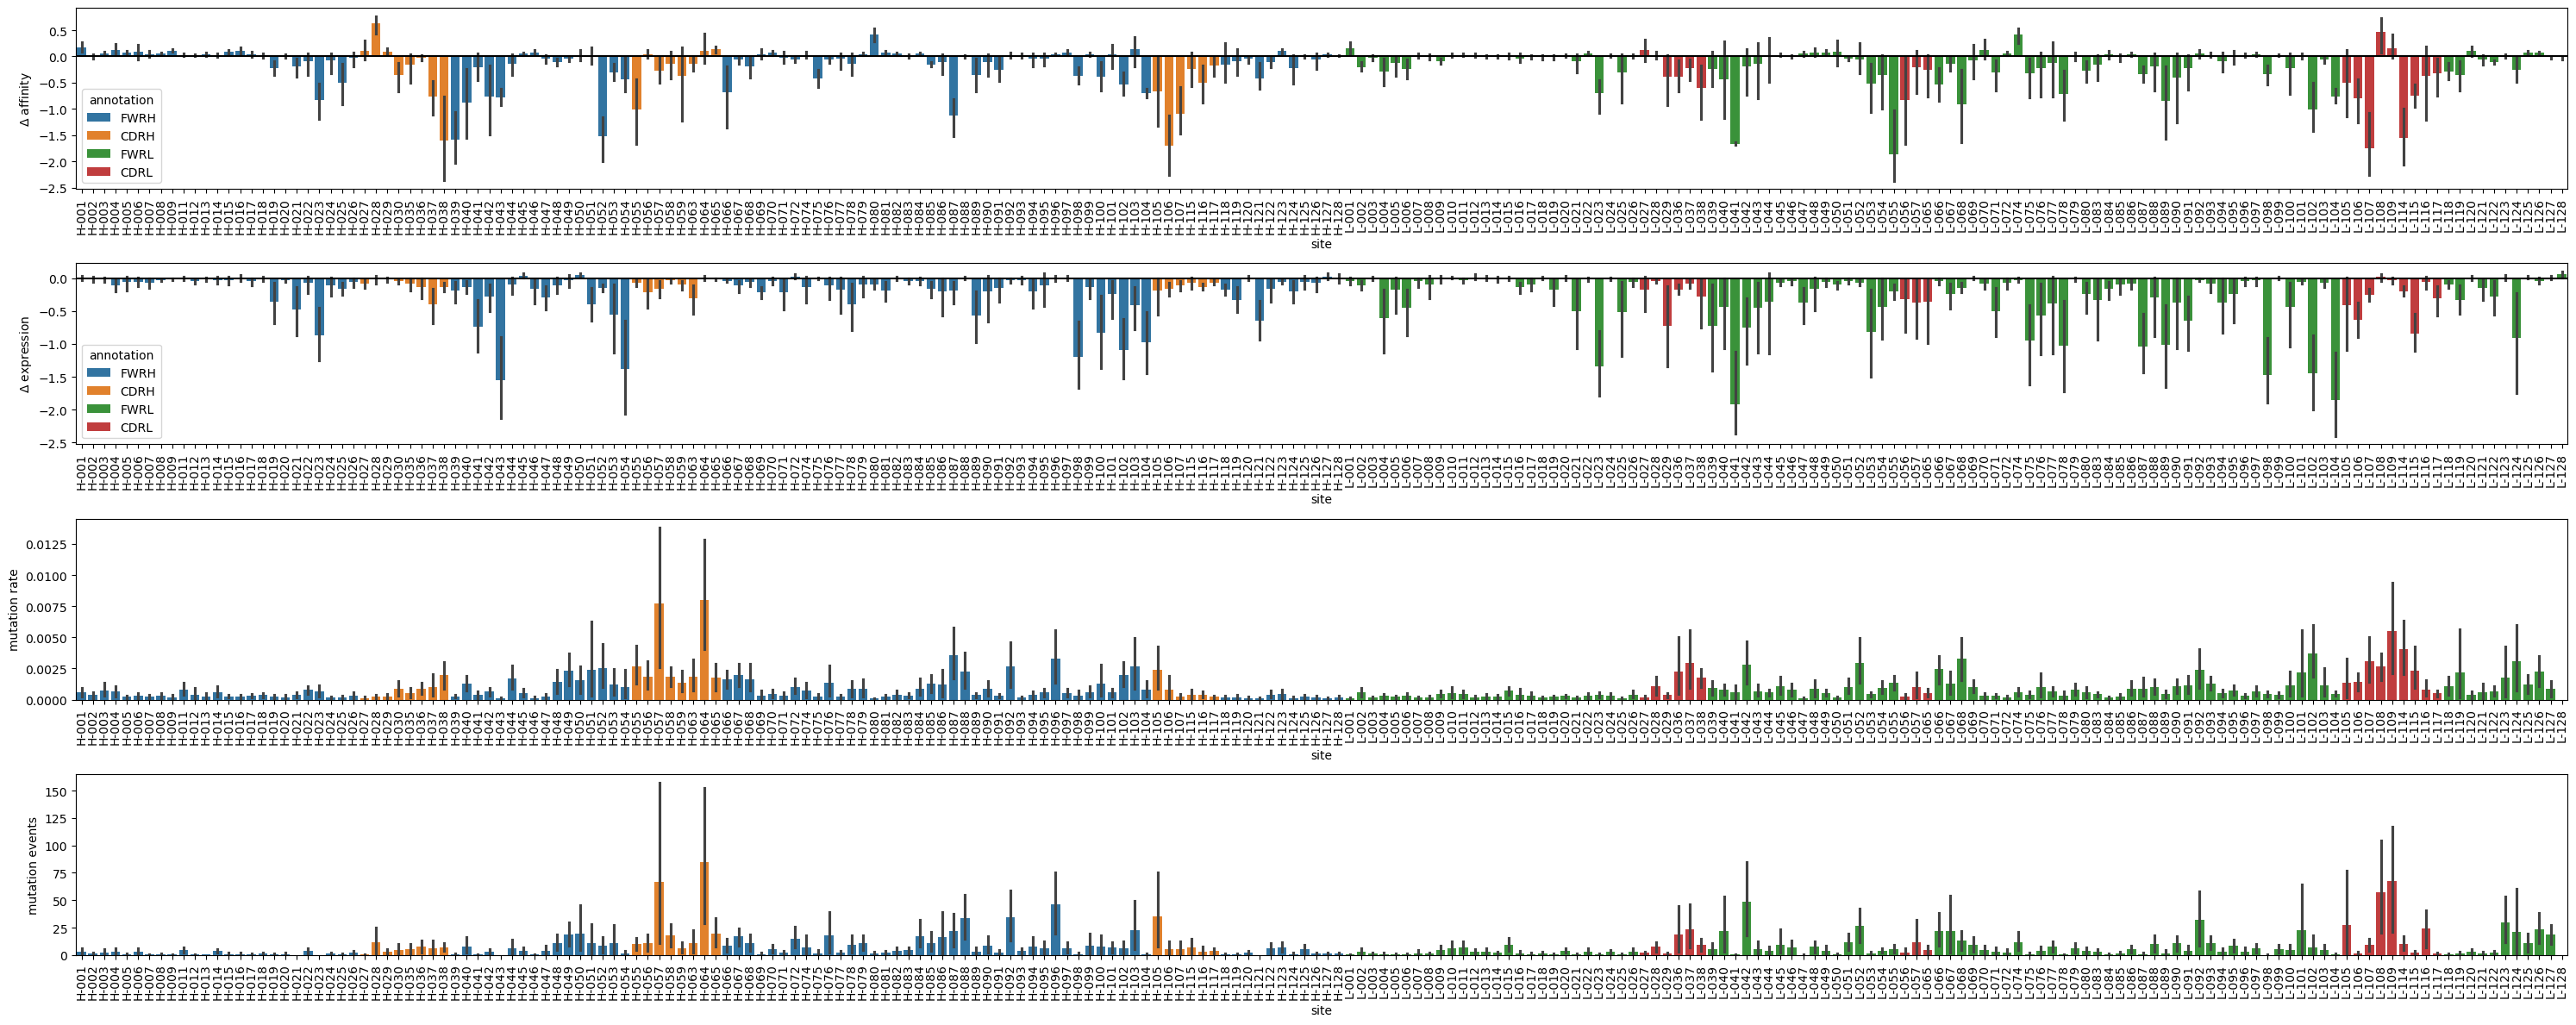

In [45]:
plt.figure(figsize=(30, 12))
plt.subplot(411)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_bind_CGG",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ affinity")
plt.xticks(rotation=90)

plt.subplot(412)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_expr",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ expression")
plt.xticks(rotation=90)

plt.subplot(413)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation rate",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.xticks(rotation=90)
g.legend_.remove()

plt.subplot(414)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation events",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
g.legend_.remove()
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{out_dir}/regions.pdf")
plt.show()

## Binding Vs Expression Vs structure

In [46]:
# copypasta from polyclonal
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)

In [47]:
# def residue_depth(
#     input_pdbfile,
#     target_chain,
# ):
#     parser = Bio.PDB.PDBParser()
#     # read PDB, catch warnings about discontinuous chains
#     with warnings.catch_warnings():
#         warnings.simplefilter(
#             "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
#         )
#         pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)
#     model = pdb[0]
#     print(list(pdb.get_chains()))
#     rd = Bio.PDB.ResidueDepth(model)
# #     print(rd)
    
# residue_depth("combined_ch2_eh2-coot_IMGT.pdb", "H")

In [48]:
!curl https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/dms-view/dms-view/combined_ch2_eh2-coot_IMGT.pdb -o combined_ch2_eh2-coot_IMGT.pdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  376k  100  376k    0     0  1144k      0 --:--:-- --:--:-- --:--:-- 1147k


In [49]:
coords_H = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "H").set_index("site").drop("chain", axis=1)
coords_L = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "L").set_index("site").drop("chain", axis=1)
coords_A = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "A").set_index("site").drop("chain", axis=1)
coords_B = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "B").set_index("site").drop("chain", axis=1)
coords_C = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "C").set_index("site").drop("chain", axis=1)
coords_D = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "D").set_index("site").drop("chain", axis=1)

Add distance info to dms_df

In [50]:
coords_L

,x,y,z
site,,,
1,137.317993,157.432999,169.117004
2,135.832993,154.018005,169.938995
3,134.294006,151.919998,172.697006
4,135.925995,148.505005,172.539001
5,134.113007,146.154007,174.936996
...,...,...,...
119,139.772995,135.639999,181.841003
120,140.578003,131.979996,180.955002
121,139.048996,129.811996,183.735001


In [51]:
for coords_Ab, chain in zip((coords_H, coords_L), "HL"):
    for i in coords_Ab.index:
        min_dist = np.inf
        for coords_Ag in (coords_A, coords_B, coords_C, coords_D):
            chain_min = np.linalg.norm(coords_Ab.loc[i] - coords_Ag, axis=1).min()
            if chain_min < min_dist:
                min_dist = chain_min
        dms_df.loc[(dms_df.chain == chain) & (dms_df.position_IMGT == i), "distance to antigen"] = min_dist

dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,WT,site,mutation events (15-day),mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,mutation rate,affinity change stratum,distance to antigen
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,False,H-001,0,4,0,0,4,0.000409,affinity neutral,9.796122
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,False,H-001,0,0,0,0,0,0.000000,affinity neutral,9.796122
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,False,H-001,2,7,5,2,9,0.000803,affinity neutral,9.796122
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,True,H-001,0,0,0,0,0,0.000000,NaN,9.796122
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,False,H-001,0,0,0,0,0,0.000000,affinity neutral,9.796122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN


In [52]:
dms_df.to_csv(f"{out_dir}/data.csv")

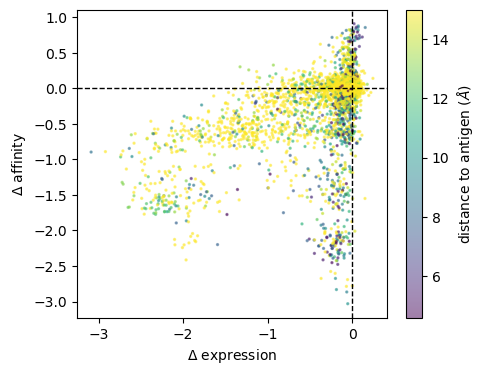

In [138]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_expr, y=dms_df.delta_bind_CGG, c=dms_df["distance to antigen"],
            s=2, alpha=0.5,
#             cmap="viridis",
#             vmin=0,
            vmax=15
           )
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ expression")
plt.ylabel(r"$\Delta$ affinity")
plt.colorbar(label=r"distance to antigen ($\AA$)")
# plt.savefig(f"{out_dir}/bind-expr-dist.pdf")
plt.show()

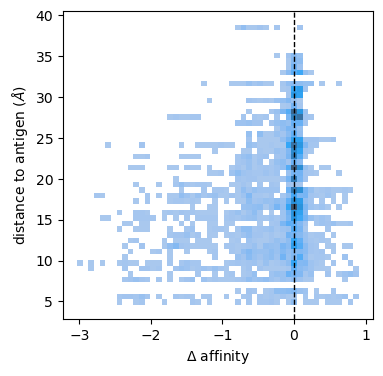

In [144]:
plt.figure(figsize=(4, 4))
sns.histplot(data=dms_df, x="delta_bind_CGG", y="distance to antigen", bins=50)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ affinity")
plt.ylabel(r"distance to antigen ($\AA$)")
plt.savefig(f"{out_dir}/bind-dist.pdf")
plt.show()

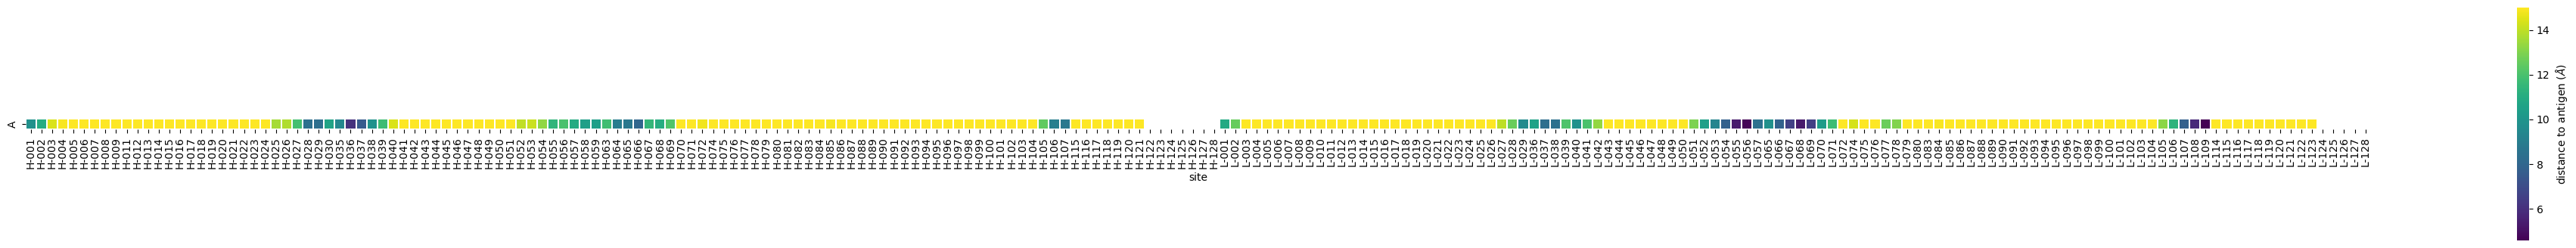

In [54]:
plt.figure(figsize=(50, 4))
sns.heatmap(pd.DataFrame(dms_df.pivot(index="mutant", columns="site", values="distance to antigen").iloc[0, :]).T,
            vmax=15, cmap="viridis",
            cbar_kws=dict(label=r"distance to antigen ($\AA$)"), linewidths=.1, square=True)
plt.savefig(f"{out_dir}/bind-heatmap-distances-row.pdf")
plt.show()

## High-incidence mutations

In [55]:
dms_df[["mutation events", "delta_bind_CGG"]].sort_values("mutation events", ascending=False)[:20]

,mutation events,delta_bind_CGG
mutation,,
S57(H)N,332,0.126849
S64(H)N,242,0.050258
N108(L)K,202,0.859231
S109(L)N,179,0.011334
Q105(L)H,175,0.380333
E101(L)D,148,-0.119511
A105(H)G,148,0.446073
S109(L)R,142,0.794803
Y42(L)F,142,-0.040251


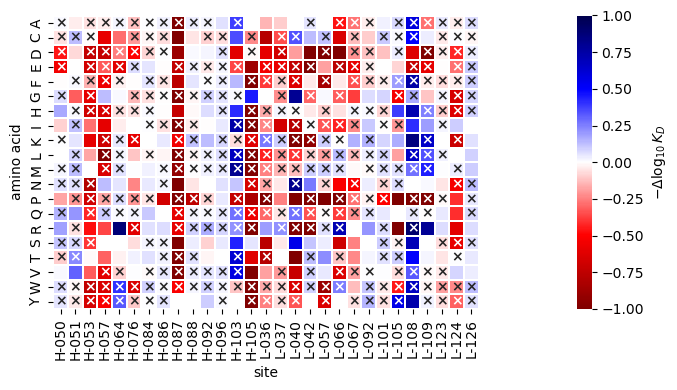

In [56]:
# high_incidence = ["H-057", "H-064", "L-108", "L-109"]
high_incidence = dms_df.loc[dms_df["mutation events"] > dms_df["mutation events"].quantile(0.99)].site.unique()

plt.figure(figsize=(20, 4))
sns.heatmap(bind_df[high_incidence], center=0, vmin=vmin, vmax=vmax, annot=annot[high_incidence], fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
# plt.savefig(f"{out_dir}/high-incidence.pdf")
plt.show()

## Pairwise epistasis

In [57]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

In [58]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        parent_mutations = set(mutation for mutation in node.up.mutations)
        new_mutations = set(mutation for mutation in node.mutations) - parent_mutations
        if any(mutation.endswith("*") for mutation in parent_mutations.union(new_mutations)):
            continue
        for new_mutation in new_mutations:
            n_mutations += 1
            mutation_counts[new_mutation] += 1
        for background_mutation in parent_mutations:
            for new_mutation in new_mutations:
                epi_df.loc[background_mutation, new_mutation] += 1

volcano_dat = []
                
for background_mutation in mutations:
    background_total = epi_df.loc[background_mutation, :].sum()
    if background_total >= 5:
        for new_mutation in mutations:
            if background_mutation[:-1] != new_mutation[:-1] and mutation_counts[new_mutation] >= 5:
                print(background_mutation, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[background_mutation, new_mutation]
                table[0, 1] = mutation_counts[new_mutation] - epi_df.loc[background_mutation, new_mutation]
                table[1, 0] = background_total - epi_df.loc[background_mutation, new_mutation]
                table[1, 1] = epi_df.loc[background_mutation, new_mutation]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                if p_value < 1e-6:
                    print(background_mutation, new_mutation, odds_ratio, p_value)
                volcano_dat.append([background_mutation, new_mutation, table, odds_ratio, p_value])

volcano_df = pd.DataFrame(volcano_dat, columns=["background mutation", "mutation event", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

epi_muts = volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")
epi_muts

A105(H)G L50(H)F 2.624359323720721 1.1799676177663591e-07
A105(H)G S57(H)N 2.388531976744186 5.046441008052655e-18
A105(H)G S64(H)R 3.5057849111664234 4.702558372349002e-15
A105(H)G D74(L)N 6.851942331538134 8.612263206289762e-07
A105(H)G Q105(L)H 2.6672501641497046 3.459334337064553e-13
A105(H)G N108(L)H 4.557600964151523 6.933932272209388e-10
A105(H)G N108(L)K 2.4220664328340247 4.441302353837531e-12
A105(H)G S109(L)N 2.3041654953219783 2.9667251531652987e-10
A105(H)G S109(L)R 3.085203747685748 2.9998335984954835e-13
A105(H)G K123(L)N 3.68694885361552 5.021869993826766e-12
Q105(L)H Y42(L)F 2.378059609736105 6.959221618978251e-07
N108(L)K S109(L)N 2.2202794429041885 2.7207582436391964e-07
N108(L)K S109(L)T 2.8969244928481035 3.68611927435419e-08


,background mutation,mutation event,contingency table,odds ratio,p-value,FDR,FDR < 0.05
121531,A105(H)G,S57(H)N,"[[15903, 192], [7525, 217]]",2.388532,5.046441e-18,1.342525e-12,True
121555,A105(H)G,S64(H)R,"[[16018, 61], [7640, 102]]",3.505785,4.702558e-15,6.255202e-10,True
121944,A105(H)G,S109(L)R,"[[16017, 70], [7639, 103]]",3.085204,2.999834e-13,2.300751e-08,True
121923,A105(H)G,Q105(L)H,"[[15993, 100], [7615, 127]]",2.667250,3.459334e-13,2.300751e-08,True
121935,A105(H)G,N108(L)K,"[[15984, 118], [7606, 136]]",2.422066,4.441302e-12,2.226647e-07,True
121965,A105(H)G,K123(L)N,"[[16046, 42], [7668, 74]]",3.686949,5.021870e-12,2.226647e-07,True
121943,A105(H)G,S109(L)N,"[[15996, 113], [7618, 124]]",2.304165,2.966725e-10,1.127500e-05,True
121933,A105(H)G,N108(L)H,"[[16072, 22], [7694, 48]]",4.557601,6.933932e-10,2.305827e-05,True
243467,N108(L)K,S109(L)T,"[[16073, 89], [2930, 47]]",2.896924,3.686119e-08,1.089592e-03,True
121499,A105(H)G,L50(H)F,"[[16051, 55], [7673, 69]]",2.624359,1.179968e-07,3.139115e-03,True


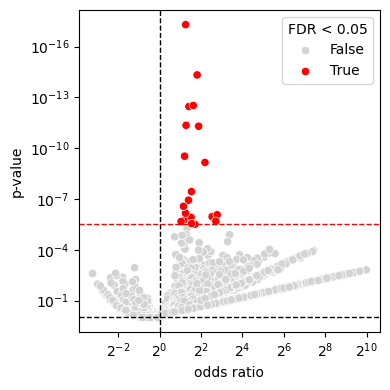

In [59]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])
ax.invert_yaxis()
plt.axvline(1, ls="--", c="k", lw=1)
plt.axhline(1, ls="--", c="k", lw=1)
plt.axhline(volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], "p-value"].max(), ls="--", c="red", lw=1)
plt.xscale("log", base=2)
plt.yscale("log")
plt.tight_layout()
# plt.savefig(f"{out_dir}/epistasis.volcano.pdf")
plt.show()

In [60]:
epi_muts.to_csv(f"{out_dir}/epistatic-pairs.csv", index=False)

Where are the above mutations in our scatters?

In [61]:
background_indicator = dms_df.index.isin(epi_muts["background mutation"])
enabled_indicator = dms_df.index.isin(epi_muts["mutation event"])
indicator = ["other"] * len(dms_df)
for i in range(len(indicator)):
    if background_indicator[i]:
        indicator[i] = "epistatic background mutation"
    elif enabled_indicator[i]:
        indicator[i] = "epistatically enabled mutation"
indicator = pd.Series(indicator, index=dms_df.index, name="mutation type")

# indicator = dms_df.index == "A40(L)G" #"A40(L)G"

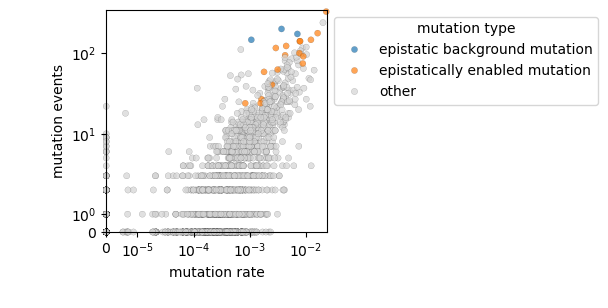

In [62]:
plt.figure(figsize=(6, 3))

ax = sns.scatterplot(x=dms_df["mutation rate"], y=dms_df["mutation events"], hue=indicator, s=20, alpha=0.7,
                     hue_order=("epistatic background mutation", "epistatically enabled mutation", "other"),
                     palette=("C0", "C1", "lightgrey"),
                     clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 1e-5
linthresh_y = 1.0
plt.xscale("symlog", linthresh=linthresh_x, linscale=.5)
plt.yscale("symlog", linthresh=linthresh_y, linscale=.2)
plt.xlim(0, None)
plt.ylim(0, None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(f"{out_dir}/eventsVsrate-epistatic.pdf")
plt.show()

LBI of nodes with the above mutations

,LBI,LBR,mutation pair on tree node
0,8.640913,0.303077,enabling and enabled mutation
1,8.976038,0.364408,enabling mutation only
2,11.015386,0.759783,enabling and enabled mutation
3,12.300752,1.030387,enabling and enabled mutation
4,5.453821,0.601755,enabling and enabled mutation
...,...,...,...
705,4.600888,0.524202,enabled mutation only
706,5.150001,0.711925,enabled mutation only
707,10.170254,0.815691,enabling and enabled mutation
708,1.807571,0.000000,enabling mutation only


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


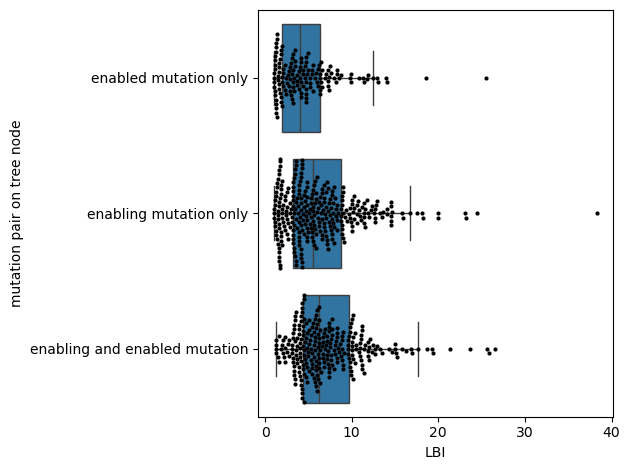

In [63]:
lbi_dat = []
pairs = set((x, y) for x, y in volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], ["background mutation", "mutation event"]].values)
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        mutations = set(node.mutations)
        # if node.get_distance(tree.tree) <= 4:
        if len(mutations) == 2:
            if any(set(pair) <= mutations for pair in pairs):            
                lbi_dat.append([node.LBI, node.LBR, "enabling and enabled mutation"])
            elif any(pair[0] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabling mutation only"])
            elif any(pair[1] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabled mutation only"])
            # else:
            #     lbi_dat.append([node.LBI, node.LBR, "none"])

lbi_df = pd.DataFrame(lbi_dat, columns=("LBI", "LBR", "mutation pair on tree node"))

display(lbi_df)

# plt.figure(figsize=(10, 3))
sns.boxplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), fliersize=0)
sns.swarmplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), color="k", size=3)
plt.tight_layout()
# plt.savefig(f"{out_dir}/epistasis.LBI.pdf")
plt.show()


In [64]:
from scipy.stats import kruskal, mannwhitneyu

kruskal(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

KruskalResult(statistic=48.85693715858945, pvalue=2.4595230367355292e-11)

In [65]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI)

MannwhitneyuResult(statistic=16371.0, pvalue=2.4307558964199064e-05)

In [66]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=10985.0, pvalue=1.8172279670193487e-12)

In [67]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=33313.5, pvalue=0.0007389583325758093)

### Redoing above using Yun's approach of coincidence of mutations on nodes

In [68]:
n_mutations, mutation_counts.sum()

(16120, 16120)

In [69]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        if any(mutation.endswith("*") for mutation in node.mutations):
            continue
        for i, mutation1 in enumerate(node.mutations):
            n_mutations += 1
            mutation_counts[mutation1] += 1
            for mutation2 in node.mutations[i + 1:]:
                epi_df.loc[mutation1, mutation2] += 1

volcano_dat = []
                
for i, mutation1 in enumerate(mutations):
    mutation1_total = mutation_counts[mutation1]
    if mutation1_total >= 50:
        for mutation2 in mutations[i + 1:]:
            if mutation1[:-1] != mutation2[:-1] and mutation_counts[mutation2] >= 5:
                print(mutation1, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[mutation1, mutation2]
                table[0, 1] = mutation_counts[mutation2] - epi_df.loc[mutation1, mutation2]
                table[1, 0] = mutation1_total - epi_df.loc[mutation1, mutation2]
                table[1, 1] = epi_df.loc[mutation1, mutation2]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                row = [mutation1, mutation2, table, odds_ratio, p_value]
                # if p_value < 1e-6:
                #     print(row)
                volcano_dat.append(row)

volcano_df = pd.DataFrame(volcano_dat, columns=["mutation 1", "mutation 2", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")

,mutation 1,mutation 2,contingency table,odds ratio,p-value,FDR,FDR < 0.05
11192,S57(H)N,S64(H)R,"[[46496, 496], [976, 398]]",38.226732,0.000000,0.000000,True
11342,S57(H)N,A105(H)G,"[[46056, 4119], [536, 838]]",17.481297,0.000000,0.000000,True
34558,A105(H)G,S109(L)R,"[[46386, 226], [4449, 508]]",23.435800,0.000000,0.000000,True
16501,S64(H)R,A105(H)G,"[[46274, 4337], [274, 620]]",24.142862,0.000000,0.000000,True
34548,A105(H)G,N108(L)K,"[[45531, 680], [3594, 1363]]",25.393120,0.000000,0.000000,True
...,...,...,...,...,...,...,...
47553,S109(L)T,K123(L)E,"[[46890, 93], [325, 4]]",6.205459,0.004790,0.049321,True
10781,I56(H)M,T95(H)I,"[[46892, 91], [50, 2]]",20.611868,0.004809,0.049501,True
36907,S7(L)P,N108(L)D,"[[46892, 57], [80, 2]]",20.566667,0.004817,0.049575,True
43610,A52(L)T,E101(L)D,"[[46890, 344], [88, 4]]",6.195825,0.004832,0.049713,True
